# Analyze A/B Test Results 

We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion & Recommendation](#Conclusion)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, i will be working to understand the results of an A/B test run by an e-commerce website.  my goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').count()[0]

3893

**f.** Do any of the rows have missing values?

In [7]:
df.isnull().sum().sum()

0

**So, there is no missing values in all rows.**

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.query('(group == "control" and landing_page == "old_page") or (group == "treatment" and landing_page == "new_page")')

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The user_id **773192** is repeated in the data set.

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
df2.query('user_id == 773192')

# We can use df.user_id.duplicated().index to get the row index to drop it.

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop(df2.query('user_id == 773192 and timestamp == "2017-01-09 05:37:58.781806"').index)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


**So, there is no repeated useres now**

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [14]:
p_population = df2.converted.mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_conv = df2.query('group == "control"').converted.mean()
control_conv

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_conv = df2.query('group == "treatment"').converted.mean()
treatment_conv

0.11880806551510564

In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_conv - control_conv
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [18]:
df2.landing_page.value_counts()['new_page'] / df2.shape[0]

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**From the difference between the conversion rate between the old page and new page we notice that, the rate for the old page is slightly higher than that of the new page. But it is 0.0015 and this can not make us sure from these results till now.**

---

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.


> H0: $p_{old}$ - $p_{new}$ ${>=}$ 0
>
> H1: $p_{old}$ - $p_{new}$ ${<}$ 0

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [19]:
p = df2.converted.mean()
p

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [20]:
p

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [21]:
numberOf_newPage = df2.group.value_counts()['treatment']
numberOf_newPage

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
numberOf_oldPage = df2.group.value_counts()['control']
numberOf_oldPage

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [23]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0, 1], size=numberOf_newPage, replace=True, p=[(1-p), p])
p2_new = new_page_converted.mean()

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [24]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], size=numberOf_oldPage, replace = True, p=[(1-p), p])
p2_old = old_page_converted.mean()

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [25]:
p2_diffs = p2_new - p2_old
p2_diffs

0.0009543220427730564


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [26]:
# This will return array of 10000 values ... each value is (number of ones between 0:numberOf_newPage) / numberOf_newPage
# to get propotions fo ones.
new_page_converted = np.random.binomial(numberOf_newPage, p, 10000) / numberOf_newPage
p3_new = new_page_converted.mean()
p3_new

0.11959032757552818

In [27]:
old_page_converted = np.random.binomial(numberOf_oldPage, p, 10000) / numberOf_oldPage
p3_old = old_page_converted.mean()
p3_old

0.11960439720803447

In [28]:
p_diffs = new_page_converted - old_page_converted
p3_diffs = p_diffs.mean()
p3_diffs

-1.4069632506291482e-05

**Reference:** 
- **I learned code of np.random.binomial from [here](https://www.youtube.com/watch?v=h8T2dwZJMUw)**
- **And [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.binomial.html)**

**Sampling distribution using for loops but it will be so slow.**


In [29]:
# p_diffs2 = []
# for _ in range(10000):
#     old_page_converted = np.random.choice([0, 1], size=numberOf_oldPage, replace = True, p=[(1-p), p])
#     new_page_converted = np.random.choice([0, 1], size=numberOf_newPage, replace = True, p=[(1-p), p])

#     p_diffs2.append(new_page_converted.mean() - old_page_converted.mean())


# p_diffs2 = np.array(p_diffs2)
# p_diffs2.mean()

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


In [30]:
lower, upper = np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)

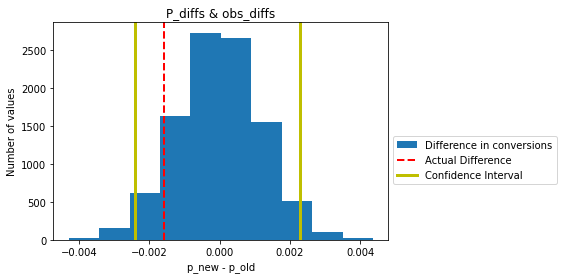

In [135]:
plt.hist(p_diffs,label='Difference in conversions');
plt.axvline(obs_diff, color='r', linewidth=2, linestyle='--', label='Actual Difference');
plt.axvline(lower, color='y', label='Confidence Interval', linewidth=3)
plt.axvline(upper, color='y', linewidth=3)
plt.xlabel('p_new - p_old');
plt.ylabel('Number of values');
plt.title('P_diffs & obs_diffs');
plt.legend(bbox_to_anchor=(1, 0.5));

As we built the p_diffs from simulating the two groups **Under the NULL Hypothesis**, we do not need to simulate the NULL using np.random.normal().

The plot of diffs is like what I expected as its mean is near zero and we simulated this process for 10,000 values so the CLT will be applied.

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

> **As the Hypothesis are:**
>
> H0: $p_{new}$ - $p_{old}$ <= 0
>
> H1: $p_{new}$ - $p_{old}$ > 0
>


In [32]:
p_value = (p_diffs > obs_diff).mean()
p_value

0.9041

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

> In the question j, we calculated the **P-Value**.
>
> **P-value** is the probability of obtaining results at least as extreme as the observed results of a statistical hypothesis test, assuming that the null hypothesis is correct.
>
> As the P-value is 0.9 > 0.05 so we have evidence that we **Fail to reject NULL Hypothesis** and there is no difference between the to pages or the Old one is better.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [33]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('group == "control" and converted == 1').count()[0]

# number of conversions with the new_page
convert_new = df2.query('group == "treatment" and converted == 1').count()[0]

# number of individuals who were shown the old_page
n_old = df2.query('group == "control"').count()[0]

# number of individuals who received new_page
n_new = df2.query('group == "treatment"').count()[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{(p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org


In [136]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array(n_new, n_old), alternative = 'larger')
print(f'Z_score = {z_score}\np_value = {p_value}')

Z_score = -1.286299137965753
p_value = 0.9008306583826964


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>ِ As the $Z_{\alpha}$ for one tailed on 95% confidence interval = 1.96 > $Z_{score}$ = -1.2 ... So, **Fail to reject NULL Hypothesis** as we got from j, k questions. 

**Reference:** 
- **I learned about Z-test from [here](https://www.youtube.com/watch?v=rEyV6vY6ZmU&t=1844s)**


---

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [90]:
df2['intercept'] = 1
df2[['control_column', 'ab_page']] = pd.get_dummies(df['group'])

In [93]:
# Dropping the control_column to get rid off Multicollinearity
df2.drop(columns='control_column', inplace=True)
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [94]:
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [95]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-08-15 03:14 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

> P-Value of ab_page is **0.1899**
>
> As The Hypotheses for these parameters are:
>
> H_0 : ${\beta}$ = 0
>
> H_1 : ${\beta}{\ne}0 $ 
>
> So, the p-value of ab_page > 0.05 so we **Fail to reject the NULL Hypothesis** So, ${\beta}$ = 0
> So this suggests that the ab_page column isn't statistically significant in predicting if conversion is 1 or 0.
> 
> And this matches the previous p-value as we fail to reject the Null Hypothesis and there is no difference between the two pages.


**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> * Yes i cosider other things might influence whether or not an individual convers like:
>  * Gender of user.
>  * Age of user.
> * As it is good idea to cosider them as there are other factors influence the coversion rate.
> * It is also important not to consider many factors in our model as it may be affected by problems like:
>  * Outliers.
>  * Multicollinearity.
>  * No linear relationship exist.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [96]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head(2)

,user_id,country
0,834778,UK
1,928468,US


In [97]:
# Join with the df2 dataframe
df_merged = pd.merge(df2, countries, on='user_id')
df_merged.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US


In [98]:
# Create the necessary dummy variables
countries = list(df_merged.country.value_counts().index)
df_merged[countries] = pd.get_dummies(df_merged['country'])
df_merged.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1


In [ ]:
df_merged.drop(columns='CA', inplace=True)
df_merged.head(1)

In [106]:
model2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK' , 'US']])
results2 = model2.fit()

results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-08-15 03:33 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
US           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
==================================================================

"""

In [107]:
np.exp(results2.params)

intercept    0.136795
ab_page      0.985168
UK           1.009932
US           0.960062
dtype: float64

In [108]:
1 / np.exp(results2.params)

intercept    7.310207
ab_page      1.015056
UK           0.990165
US           1.041599
dtype: float64

> * As we see for p-values of all parameters we see also **ab_page and countries has no impact on predicting conversion.**
>
>
> * For every **one unite decrease in x1** "Of ab_page" we excpect **conversion is 1.015 times based on the baseline holding all other variables.**
>
>
> * For every **one unite decrease in x2** "Of US" we excpect **conversion is 1.041 times based on the baseline `CA` holding all other variables.**
>
>
> * For every **one unite increase in x3** "Of UK" we excpect **conversion is 1.009 times based on the baseline `CA` holding all other variables.**

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [111]:
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_US'] = df_merged['ab_page'] * df_merged['US']

In [125]:
# Fit your model, and summarize the results
model3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK' , 'US', 'ab_UK', 'ab_US']])
results3 = model3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [126]:
results3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-08-15 03:56 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
US           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
ab_UK         0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
ab_US        -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

> * As we see for p-values of all parameters we see also **ab_page and countries and the intersection of countries with ab_page has no impact on predicting conversion.**


<a id='Conclusion'></a>
## Conclusion & Recommendation

> * From **Part I - Probability** we got:
>  * The conversion rate on the old page is greater than the new page by 0.001578.
>
>
> * From **Part II - A/B test** we got:
>  * We fail to reject the Null Hypothesis, so it makes us go with staying with the old page.
>
>
> * From **Part III - Regression** we got:
>  * There is no statistically significant linear relationship between countries or ab_page and the conversion rate. So, they will not help us predict the response.


> **So, my recommendation based on this analysis is to `stay with the old web page.`**